<a href="https://colab.research.google.com/github/Nalina655/Nalina655/blob/main/Copy_of_rapid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gtfs-realtime-bindings requests


  Preparing metadata (setup.py) ... done
  Created wheel for gtfs-realtime-bindings: filename=gtfs_realtime_bindings-1.0.0-py3-none-any.whl size=5987 sha256=525965111300e138b54769f40da8dd3dde06de33b2ecdc489794667e396d77c9
  Stored in directory: /root/.cache/pip/wheels/de/77/98/c97c7fb5e3a7359e3f83c9c4a62115d3700e9b5445854ca122
Successfully built gtfs-realtime-bindings


In [2]:
import time
import requests
from datetime import datetime, timedelta
from google.transit import gtfs_realtime_pb2

# ======== 🔐 API KEYS ===========
MTA_API_KEY = "bab3392b-58f0-42c2-8b61-421d6a03e72e"
TOMTOM_API_KEY = "gmKSHRhMEQ1oXOnhV5wKL2B3WE45SZL9"
OPENWEATHER_API_KEY = "d7836e8948f06edd3c191fa978ff266f"

# ======== 🌐 API URLs ===========
MTA_API_URL = "https://gtfsrt.prod.obanyc.com/vehiclePositions"
TOMTOM_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
OPENWEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"
REVERSE_GEOCODE_URL = "https://nominatim.openstreetmap.org/reverse"

# ======== 🚍 MTA GTFS Bus Fetch ===========
def fetch_mta_data():
    headers = {"x-api-key": MTA_API_KEY}
    response = requests.get(MTA_API_URL, headers=headers)

    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(response.content)

    buses = []
    for entity in feed.entity:
        if entity.HasField("vehicle"):
            v = entity.vehicle
            buses.append({
                "vehicle_id": v.vehicle.id,
                "trip_id": v.trip.trip_id,
                "route_id": v.trip.route_id,
                "latitude": v.position.latitude,
                "longitude": v.position.longitude,
                "timestamp": v.timestamp,
                "speed": v.position.speed if v.position.HasField("speed") else None
            })
    return buses

# ======== 🌍 Reverse Geocoding ===========
def get_place_name(lat, lon):
    params = {
        "lat": lat,
        "lon": lon,
        "format": "json"
    }
    try:
        r = requests.get(REVERSE_GEOCODE_URL, params=params, headers={"User-Agent": "MTA-Bus-Tracker/1.0"})
        if r.status_code == 200:
            data = r.json()
            return data.get("display_name", "Unknown Location")
    except:
        pass
    return "Unknown Location"

# ======== ⏱️ Convert to IST ===========
def convert_to_ist(utc_timestamp):
    utc_time = datetime.utcfromtimestamp(utc_timestamp)
    ist_time = utc_time + timedelta(hours=5, minutes=30)
    return ist_time.strftime("%H:%M:%S")

# ======== 🚗 TomTom Traffic Fetch ===========
def fetch_traffic(lat, lon):
    params = {
        "point": f"{lat},{lon}",
        "unit": "KMPH",
        "key": TOMTOM_API_KEY
    }
    r = requests.get(TOMTOM_URL, params=params)
    if r.status_code == 200:
        d = r.json()
        return {
            "current_speed": d["flowSegmentData"]["currentSpeed"],
            "free_flow_speed": d["flowSegmentData"]["freeFlowSpeed"],
            "traffic_ratio": round(d["flowSegmentData"]["currentTravelTime"] / d["flowSegmentData"]["freeFlowTravelTime"], 2)
        }
    return None

# ======== 🌦 OpenWeather Fetch ===========
def fetch_weather(lat, lon):
    params = {
        "lat": lat,
        "lon": lon,
        "appid": OPENWEATHER_API_KEY,
        "units": "metric"
    }
    r = requests.get(OPENWEATHER_URL, params=params)
    if r.status_code == 200:
        d = r.json()
        return {
            "temperature": d["main"]["temp"],
            "humidity": d["main"]["humidity"],
            "weather": d["weather"][0]["main"],
            "wind_speed": d["wind"]["speed"]
        }
    return None

# ======== 🔁 Loop to Fetch and Print Data ===========
def poll_data():
    while True:
        print("\n=== Fetching real-time bus + traffic + weather data ===")
        buses = fetch_mta_data()
        for bus in buses[:5]:  # Limit for demo
            lat = bus["latitude"]
            lon = bus["longitude"]
            place_name = get_place_name(lat, lon)
            ist_time = convert_to_ist(bus["timestamp"])

            traffic = fetch_traffic(lat, lon)
            weather = fetch_weather(lat, lon)

            print(f"\n🚌 Bus ID: {bus['vehicle_id']} | Route: {bus['route_id']} | Trip: {bus['trip_id']}")
            print(f"📍 Location: {place_name} ({lat:.5f}, {lon:.5f})")
            print(f"🕒 Timestamp (IST): {ist_time}")

            # 🚗 Traffic Output
            if traffic:
                print(f"🚗 Traffic - Current Speed: {traffic['current_speed']} km/h | "
                      f"Free Flow Speed: {traffic['free_flow_speed']} km/h | "
                      f"Ratio: {traffic['traffic_ratio']}")
                if traffic["traffic_ratio"] > 1.1:
                    delay_sec = int((traffic["traffic_ratio"] - 1) * 60)
                    print(f"🕓 Bus likely delayed due to traffic (~{delay_sec} sec)")
            else:
                print("🚗 Traffic data not available.")

            # 🌦 Weather Output
            if weather:
                print(f"🌦 Weather - Temp: {weather['temperature']}°C | "
                      f"Humidity: {weather['humidity']}% | "
                      f"Condition: {weather['weather']} | "
                      f"Wind: {weather['wind_speed']} m/s")

                if weather['weather'] in ["Rain", "Snow", "Thunderstorm", "Drizzle"]:
                    print("☔ Weather may cause delays.")
            else:
                print("🌦 Weather data not available.")

        time.sleep(30)

# ======== 🚀 Main ===========
if __name__ == "__main__":
    poll_data()


=== Fetching real-time bus + traffic + weather data ===

🚌 Bus ID: MTA NYCT_8440 | Route: Q85 | Trip: JA_C5-Weekday-SDon-064800_MISC_832
📍 Location: Archer Avenue, Jamaica, Queens, Queens County, City of New York, New York, 11433, United States (40.70255, -73.79950)
🕒 Timestamp (IST): 21:19:22
🚗 Traffic - Current Speed: 12 km/h | Free Flow Speed: 20 km/h | Ratio: 1.67
🕓 Bus likely delayed due to traffic (~40 sec)
🌦 Weather - Temp: 24.82°C | Humidity: 85% | Condition: Clouds | Wind: 4.63 m/s

🚌 Bus ID: MTA NYCT_9770 | Route: BX28 | Trip: GH_C5-Weekday-SDon-068100_BX238_630
📍 Location: 957, East Gun Hill Road, Williams Bridge, The Bronx, Bronx County, City of New York, New York, 10469, United States (40.87489, -73.85854)
🕒 Timestamp (IST): 21:19:15
🚗 Traffic - Current Speed: 14 km/h | Free Flow Speed: 22 km/h | Ratio: 1.57
🕓 Bus likely delayed due to traffic (~34 sec)
🌦 Weather - Temp: 25.67°C | Humidity: 81% | Condition: Clouds | Wind: 2.57 m/s

🚌 Bus ID: MTA NYCT_8443 | Route: Q4 | Tr

KeyboardInterrupt: 

In [3]:
import time
import requests
import csv
from datetime import datetime
from google.transit import gtfs_realtime_pb2
import os

# === API KEYS ===
MTA_API_KEY = "bab3392b-58f0-42c2-8b61-421d6a03e72e"
TOMTOM_API_KEY = "gmKSHRhMEQ1oXOnhV5wKL2B3WE45SZL9"
OPENWEATHER_API_KEY = "d7836e8948f06edd3c191fa978ff266f"

# === API URLs ===
MTA_API_URL = "https://gtfsrt.prod.obanyc.com/vehiclePositions"
TOMTOM_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
OPENWEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"

# === Data Fetch Functions ===
def fetch_mta_data():
    headers = {"x-api-key": MTA_API_KEY}
    try:
        response = requests.get(MTA_API_URL, headers=headers)
        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(response.content)

        buses = []
        for entity in feed.entity:
            if entity.HasField("vehicle"):
                v = entity.vehicle
                buses.append({
                    "vehicle_id": v.vehicle.id,
                    "trip_id": v.trip.trip_id,
                    "route_id": v.trip.route_id,
                    "latitude": v.position.latitude,
                    "longitude": v.position.longitude,
                    "timestamp": datetime.utcfromtimestamp(v.timestamp).strftime("%Y-%m-%d %H:%M:%S"),
                    "speed": v.position.speed if v.position.HasField("speed") else 0
                })
        return buses
    except Exception as e:
        print("Error fetching MTA data:", e)
        return []

def fetch_traffic(lat, lon):
    try:
        params = {"point": f"{lat},{lon}", "unit": "KMPH", "key": TOMTOM_API_KEY}
        r = requests.get(TOMTOM_URL, params=params)
        if r.status_code == 200:
            d = r.json()
            current = d["flowSegmentData"]["currentTravelTime"]
            free = d["flowSegmentData"]["freeFlowTravelTime"]
            return round(current / free, 2)
    except Exception as e:
        print("Error fetching traffic:", e)
    return 1.0  # Assume normal if failed

def fetch_weather(lat, lon):
    try:
        params = {"lat": lat, "lon": lon, "appid": OPENWEATHER_API_KEY, "units": "metric"}
        r = requests.get(OPENWEATHER_URL, params=params)
        if r.status_code == 200:
            d = r.json()
            return d["main"]["temp"], d["weather"][0]["main"]
    except Exception as e:
        print("Error fetching weather:", e)
    return 25.0, "Clear"

# === Main Data Logging Function ===
def log_data_to_csv(filename="bus_data_log.csv"):
    header = ["timestamp", "vehicle_id", "latitude", "longitude", "speed", "traffic_ratio", "temperature", "weather", "delay_estimate_sec"]
    print(f"📂 Logging to: {os.path.abspath(filename)}")

    # Write header if file doesn't exist
    if not os.path.exists(filename):
        with open(filename, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header)

    while True:
        print("🔄 Fetching new data...")
        buses = fetch_mta_data()
        print(f"✅ Buses fetched: {len(buses)}")

        if not buses:
            print("⚠️ No bus data returned. Retrying in 30s...")
            time.sleep(30)
            continue

        rows_written = 0
        with open(filename, "a", newline="") as f:
            writer = csv.writer(f)
            for bus in buses[:10]:  # Limit to 10 buses
                lat = bus["latitude"]
                lon = bus["longitude"]
                traffic_ratio = fetch_traffic(lat, lon)
                temp, cond = fetch_weather(lat, lon)
                delay_est = int((traffic_ratio - 1.0) * 60) if traffic_ratio > 1.0 else 0

                writer.writerow([
                    bus["timestamp"],
                    bus["vehicle_id"],
                    lat,
                    lon,
                    bus["speed"],
                    traffic_ratio,
                    temp,
                    cond,
                    delay_est
                ])
                rows_written += 1

        print(f"📝 {rows_written} entries written to CSV.\n")
        time.sleep(30)

# === Run ===
if __name__ == "__main__":
    log_data_to_csv()


📂 Logging to: /content/bus_data_log.csv
🔄 Fetching new data...
✅ Buses fetched: 2339
📝 10 entries written to CSV.

🔄 Fetching new data...
✅ Buses fetched: 2350
📝 10 entries written to CSV.



KeyboardInterrupt: 

In [4]:
pip install pandas numpy scikit-learn tensorflow


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# === 1. Load and clean data ===
df = pd.read_csv("bus_data_log.csv")
df.dropna(subset=["traffic_ratio", "temperature", "weather", "delay_estimate_sec"], inplace=True)

# === 2. Encode 'weather' ===
weather_encoder = LabelEncoder()
df["weather_encoded"] = weather_encoder.fit_transform(df["weather"])
joblib.dump(weather_encoder, "weather_encoder.pkl")

# === 3. Select features & normalize ===
features = ["traffic_ratio", "temperature", "weather_encoded"]
target = "delay_estimate_sec"

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df[target].values
joblib.dump(scaler, "feature_scaler.pkl")

# === 4. Make LSTM sequences ===
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps=5)
print("✅ LSTM input shape:", X_seq.shape)

# === 5. Build LSTM ===
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# ✅ FIXED: Use full names for loss and metrics
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

# === 6. Train ===
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X_seq, y_seq, epochs=30, batch_size=32, callbacks=[early_stop])

# === 7. Save the model cleanly ===
model.save("lstm_eta_model.h5")
print("✅ Clean model saved as lstm_eta_model.h5 (no 'mae' error)")


✅ LSTM input shape: (15, 5, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 25.6580 - mean_absolute_error: 25.6580
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 25.6458 - mean_absolute_error: 25.6458
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 25.6262 - mean_absolute_error: 25.6262
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 25.6270 - mean_absolute_error: 25.6270
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 25.6088 - mean_absolute_error: 25.6088
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 25.5959 - mean_absolute_error: 25.5959
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 25.6012 - mean_absolute_error: 25.6012
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 25.5948 - mean_absolute_error: 25.5948
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 25.5760 - mean_absolute_error: 25.5760
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 25.5614 - mean_absolute_error: 25.5614
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

✅ Clean model saved as lstm_eta_model.h5 (no 'mae' error)


In [6]:
pip install tensorflow pandas numpy requests scikit-learn protobuf


In [7]:
import time
import requests
import numpy as np
import pandas as pd
import joblib
from datetime import datetime, timedelta
from google.transit import gtfs_realtime_pb2
from tensorflow.keras.models import load_model

# === Load trained model and preprocessors ===
model = load_model("lstm_eta_model.h5")
scaler = joblib.load("feature_scaler.pkl")
weather_encoder = joblib.load("weather_encoder.pkl")

# === API KEYS ===
MTA_API_KEY = "bab3392b-58f0-42c2-8b61-421d6a03e72e"
TOMTOM_API_KEY = "gmKSHRhMEQ1oXOnhV5wKL2B3WE45SZL9"
OPENWEATHER_API_KEY = "d7836e8948f06edd3c191fa978ff266f"

# === API URLs ===
MTA_API_URL = "https://gtfsrt.prod.obanyc.com/vehiclePositions"
TOMTOM_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
OPENWEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"

# === Fetch functions ===
def fetch_mta_data():
    headers = {"x-api-key": MTA_API_KEY}
    try:
        response = requests.get(MTA_API_URL, headers=headers)
        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(response.content)
        buses = []
        for entity in feed.entity:
            if entity.HasField("vehicle"):
                v = entity.vehicle
                buses.append({
                    "vehicle_id": v.vehicle.id,
                    "route_id": v.trip.route_id,
                    "trip_id": v.trip.trip_id,
                    "latitude": v.position.latitude,
                    "longitude": v.position.longitude,
                    "timestamp": v.timestamp
                })
        return buses
    except:
        return []

def fetch_traffic(lat, lon):
    try:
        params = {"point": f"{lat},{lon}", "unit": "KMPH", "key": TOMTOM_API_KEY}
        r = requests.get(TOMTOM_URL, params=params)
        if r.status_code == 200:
            d = r.json()
            return round(d["flowSegmentData"]["currentTravelTime"] / d["flowSegmentData"]["freeFlowTravelTime"], 2)
    except:
        pass
    return 1.0

def fetch_weather(lat, lon):
    try:
        params = {"lat": lat, "lon": lon, "appid": OPENWEATHER_API_KEY, "units": "metric"}
        r = requests.get(OPENWEATHER_URL, params=params)
        if r.status_code == 200:
            d = r.json()
            return d["main"]["temp"], d["weather"][0]["main"]
    except:
        pass
    return 25.0, "Clear"

# === Timestamp conversion ===
def convert_to_ist(utc_timestamp):
    utc_time = datetime.utcfromtimestamp(utc_timestamp)
    ist_time = utc_time + timedelta(hours=5, minutes=30)
    return ist_time.strftime("%H:%M:%S")

# === Real-time Prediction Loop ===
def predict_eta_live():
    history = []

    while True:
        print("\n🚦 Real-time ETA Predictions —", datetime.now().strftime("%H:%M:%S"))
        buses = fetch_mta_data()

        for bus in buses[:5]:  # Limit to 5 buses
            lat = bus["latitude"]
            lon = bus["longitude"]
            ts = bus["timestamp"]
            vehicle_id = bus["vehicle_id"]

            traffic_ratio = fetch_traffic(lat, lon)
            temp, weather = fetch_weather(lat, lon)
            ist_time = convert_to_ist(ts)

            # Handle unseen weather labels
            if weather in weather_encoder.classes_:
                weather_code = weather_encoder.transform([weather])[0]
            else:
                weather_code = 0

            # Add new point to history
            point = [traffic_ratio, temp, weather_code]
            history.append(point)

            if len(history) < 5:
                print(f"⏳ Waiting for 5 samples... ({len(history)}/5) for {vehicle_id}")
                continue

            # Use only last 5 steps
            X = np.array(history[-5:])  # (5, 3)
            X_scaled = scaler.transform(X).reshape(1, 5, 3)

            # Predict delay
            eta_delay = float(model.predict(X_scaled)[0][0])
            eta_delay = max(0, round(eta_delay))

            print(f"\n🚌 Bus ID: {vehicle_id}")
            print(f"📍 Location: ({lat:.5f}, {lon:.5f})")
            print(f"🕒 Time: {ist_time}")
            print(f"🚗 Traffic Ratio: {traffic_ratio}, 🌡 Temp: {temp}°C, ☁ Weather: {weather}")
            print(f"⏳ Predicted Delay: {eta_delay} seconds")

        time.sleep(30)

# === Run the script ===
if __name__ == "__main__":
    predict_eta_live()



🚦 Real-time ETA Predictions — 15:53:20
⏳ Waiting for 5 samples... (1/5) for MTA NYCT_8440
⏳ Waiting for 5 samples... (2/5) for MTA NYCT_9770
⏳ Waiting for 5 samples... (3/5) for MTA NYCT_8443
⏳ Waiting for 5 samples... (4/5) for MTA NYCT_9775


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step

🚌 Bus ID: MTA NYCT_7112
📍 Location: (40.66256, -73.82336)
🕒 Time: 21:22:43
🚗 Traffic Ratio: 1.0, 🌡 Temp: 24.86°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds

🚦 Real-time ETA Predictions — 15:53:52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



🚌 Bus ID: MTA NYCT_8440
📍 Location: (40.70259, -73.79929)
🕒 Time: 21:23:29
🚗 Traffic Ratio: 1.5, 🌡 Temp: 24.82°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

🚌 Bus ID: MTA NYCT_9770
📍 Location: (40.87756, -73.86710)
🕒 Time: 21:23:20
🚗 Traffic Ratio: 1.5, 🌡 Temp: 25.71°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🚌 Bus ID: MTA NYCT_8443
📍 Location: (40.70184, -73.80249)
🕒 Time: 21:23:11
🚗 Traffic Ratio: 1.56, 🌡 Temp: 24.82°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🚌 Bus ID: MTA NYCT_9775
📍 Location: (40.76186, -73.97477)
🕒 Time: 21:23:26
🚗 Traffic Ratio: 1.0, 🌡 Temp: 25.8°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🚌 Bus ID: MTA NYCT_7112
📍 Location: (40.66249, -73.82338)
🕒 Time: 21:23:14
🚗 Traffic Ratio: 1.0, 🌡 Temp: 24.86°C, ☁ Weather: Clouds
⏳ Predicted Delay: 1 seconds


KeyboardInterrupt: 

In [8]:
pip install streamlit streamlit-folium folium joblib tensorflow scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [9]:
!pip install streamlit streamlit-folium pyngrok


In [10]:
%%writefile eta_dashboard.py
# your streamlit app code (paste eta_dashboard.py here)

import streamlit as st
import pandas as pd
import numpy as np
import requests
import joblib
import time
from datetime import datetime, timedelta
from google.transit import gtfs_realtime_pb2
from tensorflow.keras.models import load_model
import folium
from streamlit_folium import st_folium

# === Load Model and Encoders ===
model = load_model("lstm_eta_model.h5")
scaler = joblib.load("feature_scaler.pkl")
weather_encoder = joblib.load("weather_encoder.pkl")

# === API KEYS ===
MTA_API_KEY = "bab3392b-58f0-42c2-8b61-421d6a03e72e"
TOMTOM_API_KEY = "gmKSHRhMEQ1oXOnhV5wKL2B3WE45SZL9"
OPENWEATHER_API_KEY = "d7836e8948f06edd3c191fa978ff266f"

# === API URLs ===
MTA_API_URL = "https://gtfsrt.prod.obanyc.com/vehiclePositions"
TOMTOM_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
OPENWEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"

# === Helper Functions ===
def fetch_mta_data():
    headers = {"x-api-key": MTA_API_KEY}
    response = requests.get(MTA_API_URL, headers=headers)
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(response.content)
    buses = []
    for entity in feed.entity:
        if entity.HasField("vehicle"):
            v = entity.vehicle
            buses.append({
                "vehicle_id": v.vehicle.id,
                "route_id": v.trip.route_id,
                "trip_id": v.trip.trip_id,
                "latitude": v.position.latitude,
                "longitude": v.position.longitude,
                "timestamp": v.timestamp
            })
    return buses[:10]  # Limit to 10 buses for demo

def fetch_traffic(lat, lon):
    params = {"point": f"{lat},{lon}", "unit": "KMPH", "key": TOMTOM_API_KEY}
    r = requests.get(TOMTOM_URL, params=params)
    if r.status_code == 200:
        d = r.json()
        return round(d["flowSegmentData"]["currentTravelTime"] / d["flowSegmentData"]["freeFlowTravelTime"], 2)
    return 1.0

def fetch_weather(lat, lon):
    params = {"lat": lat, "lon": lon, "appid": OPENWEATHER_API_KEY, "units": "metric"}
    r = requests.get(OPENWEATHER_URL, params=params)
    if r.status_code == 200:
        d = r.json()
        return d["main"]["temp"], d["weather"][0]["main"]
    return 25.0, "Clear"

def convert_to_ist(utc_timestamp):
    utc_time = datetime.utcfromtimestamp(utc_timestamp)
    ist_time = utc_time + timedelta(hours=5, minutes=30)
    return ist_time.strftime("%H:%M:%S")

# === Streamlit UI ===
st.set_page_config(page_title="Bus ETA Live Tracker", layout="wide")
st.title("🚌 Real-Time Bus ETA Prediction (LSTM Model)")

bus_data = fetch_mta_data()
history = []

# === Map setup ===
if bus_data:
    first = bus_data[0]
    m = folium.Map(location=[first["latitude"], first["longitude"]], zoom_start=11)

    table_data = []

    for bus in bus_data:
        lat, lon = bus["latitude"], bus["longitude"]
        traffic_ratio = fetch_traffic(lat, lon)
        temp, weather = fetch_weather(lat, lon)
        ts = bus["timestamp"]
        ist_time = convert_to_ist(ts)

        if weather in weather_encoder.classes_:
            weather_code = weather_encoder.transform([weather])[0]
        else:
            weather_code = 0

        # Sequence history per bus (5 points — simulate with last value repeated)
        point = [traffic_ratio, temp, weather_code]
        history = [point] * 5
        X = np.array(history)
        X_scaled = scaler.transform(X).reshape(1, 5, 3)

        eta = float(model.predict(X_scaled)[0][0])
        eta = max(0, round(eta))

        # Add marker to map
        popup = f"Bus ID: {bus['vehicle_id']}<br>Delay: {eta} sec<br>Weather: {weather}<br>Traffic: {traffic_ratio}"
        folium.Marker([lat, lon], tooltip=f"{bus['vehicle_id']}", popup=popup,
                      icon=folium.Icon(color="blue", icon="bus", prefix="fa")).add_to(m)

        # Add to table
        table_data.append({
            "Bus ID": bus["vehicle_id"],
            "Route": bus["route_id"],
            "Time": ist_time,
            "ETA Delay (sec)": eta,
            "Traffic Ratio": traffic_ratio,
            "Temperature (°C)": temp,
            "Weather": weather
        })

    # Render map
    st_folium(m, width=700, height=500)

    # Show table
    st.subheader("📊 Live ETA Predictions")
    st.dataframe(pd.DataFrame(table_data))
else:
    st.warning("No bus data available.")


Writing eta_dashboard.py


In [11]:
!ngrok config add-authtoken 2yVWE8TvK02yTJmkns2pm0LqvLk_6ajxnNdQgA1H12VbSwz7n


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [12]:
from pyngrok import ngrok
import os

# Kill previous tunnels (if any)
ngrok.kill()

# Start Streamlit app
public_url = ngrok.connect(8501)
print(f"🌐 Public URL: {public_url}")

# Run app in background
!streamlit run eta_dashboard.py &> streamlit_log.txt &


🌐 Public URL: NgrokTunnel: "https://6745-34-168-205-206.ngrok-free.app" -> "http://localhost:8501"


In [13]:
pip install streamlit streamlit-folium streamlit-autorefresh tensorflow joblib folium protobuf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 13.0 MB/s eta 0:00:00


In [14]:
!pip install gtfs-realtime-bindings


In [15]:
pip install seaborn matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


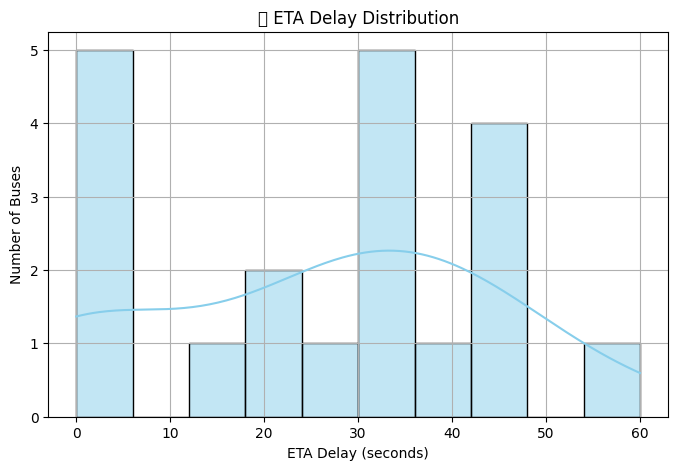

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


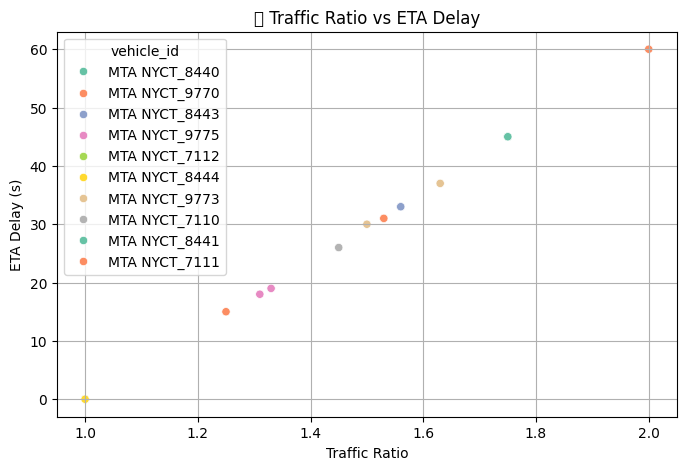

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


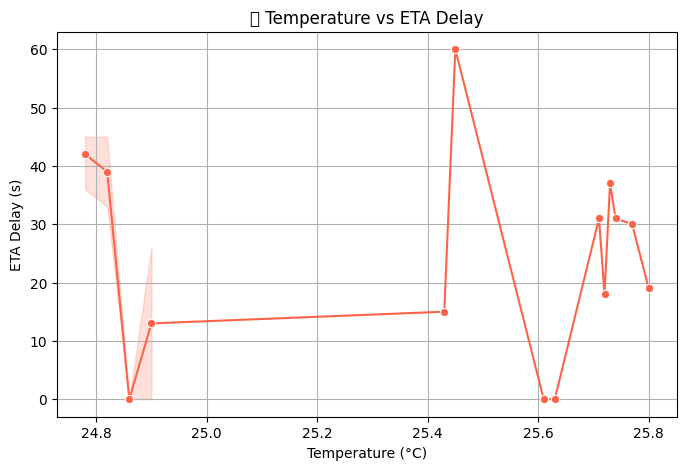

/tmp/ipython-input-20-1366259825.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_delay, x="weather", y="ETA Delay (s)", palette="coolwarm")


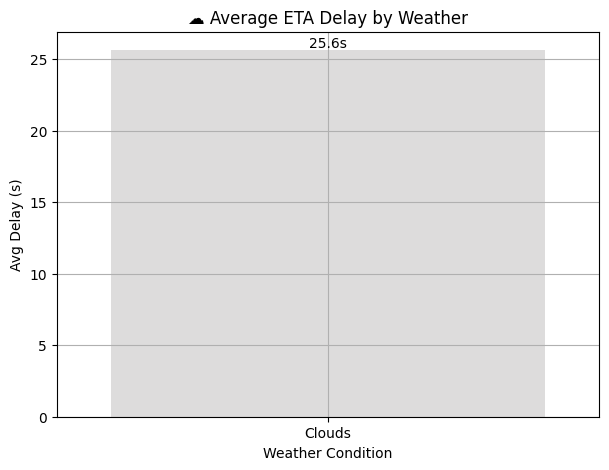

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rename the column for consistency with your original plots
df["ETA Delay (s)"] = df["delay_estimate_sec"]

# 📊 Plot 1: ETA Delay Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["ETA Delay (s)"], bins=10, kde=True, color="skyblue")
plt.title("⏳ ETA Delay Distribution")
plt.xlabel("ETA Delay (seconds)")
plt.ylabel("Number of Buses")
plt.grid(True)
plt.show()

# 📊 Plot 2: Traffic Ratio vs ETA Delay
if "traffic_ratio" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="traffic_ratio", y="ETA Delay (s)", hue="vehicle_id", palette="Set2")
    plt.title("🚗 Traffic Ratio vs ETA Delay")
    plt.xlabel("Traffic Ratio")
    plt.ylabel("ETA Delay (s)")
    plt.grid(True)
    plt.show()

# 📊 Plot 3: Temperature vs ETA Delay
if "temperature" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df.sort_values("temperature"), x="temperature", y="ETA Delay (s)", marker="o", color="tomato")
    plt.title("🌡 Temperature vs ETA Delay")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("ETA Delay (s)")
    plt.grid(True)
    plt.show()

# 📊 Plot 4: Avg Delay by Weather
if "weather" in df.columns:
    avg_delay = df.groupby("weather")["ETA Delay (s)"].mean().reset_index()
    plt.figure(figsize=(7, 5))
    sns.barplot(data=avg_delay, x="weather", y="ETA Delay (s)", palette="coolwarm")
    plt.title("☁ Average ETA Delay by Weather")
    plt.xlabel("Weather Condition")
    plt.ylabel("Avg Delay (s)")
    for i, row in avg_delay.iterrows():
        plt.text(i, row["ETA Delay (s)"] + 0.2, f"{row['ETA Delay (s)']:.1f}s", ha='center')
    plt.grid(True)
    plt.show()

# 📁 Save cleaned data
df.to_csv("cleaned_eta_data.csv", index=False)

# 📥 Download in Colab
from google.colab import files
files.download("cleaned_eta_data.csv")
